<a href="https://colab.research.google.com/github/MaryDongsn/DL_RL/blob/master/real_nvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright: https://github.com/MokkeMeguru/glow-realnvp-tutorial/blob/master/examples/jupyter_notebooks/RealNVP_mnist.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.3.0
tensorflow-probability:  0.11.0


In [ ]:

# use Tensorflow's distribution
z = tf.random.normal([2, 2, 256])
print('Tensorflow             : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))
# use Tensorflow Probability's distribution
target_dist = tfd.Normal(loc=0., scale=1.)
z = target_dist.sample([2, 2, 256])
print('Tensorflow Probability : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))

Tensorflow             : shape: (2, 2, 256) mean: -0.013998 sd: 0.978266
Tensorflow Probability : shape: (2, 2, 256) mean: -0.039691 sd: 1.035820


In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

print('train_dataset: {} images'.format(len(train_x)))
print('test_dataset : {} images'.format(len(test_x)))

11493376/11490434 [==============================] - 0s 0us/step
train_dataset: 60000 images
test_dataset : 10000 images


In [ ]:
print(test_x[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 19

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

@tf.function
def _parse_function(img, label):
    feature = {}
    img = tf.pad(img, paddings=[[2, 2], [2, 2]], mode="CONSTANT")
    img = tf.expand_dims(img, axis=-1)
    img = tf.reshape(img, [32, 32, 1])
    img = tf.cast(img, dtype=tf.float32)
    img = (img / (255.0 / 2)) - 1
    feature['img'] = img
    feature['label'] = label
    return feature

train_dataset_raw = tf.data.Dataset.from_tensor_slices((train_x, train_y)).map(_parse_function)
test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_x, test_y)).map(_parse_function)

tf.Tensor(
[[[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 ...

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]], shape=(32, 32, 1), dtype=float32)


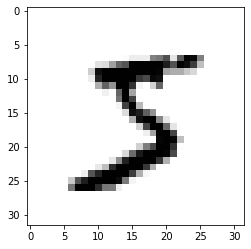

In [14]:

for image_features in train_dataset_raw.take(1):
    print(image_features['img'])
    plt.imshow(tf.squeeze(image_features['img'], axis=-1), cmap='gray_r')

In [ ]:
from tensorflow.keras.layers import Layer, BatchNormalization, ReLU, Conv2D
from tensorflow.keras import Model


class NN(Layer):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        kernel_size=[[3, 3], [1, 1]],
        strides=[[1, 1], [1, 1]],
        activation="relu",
        name=None,
    ):
        if name:
            super(NN, self).__init__(name=name)
        else:
            super(NN, self).__init__()
        layer_list = []
        for i, (hidden, kernel, stride) in enumerate(
            zip(n_hidden, kernel_size, strides)
        ):
            layer_list.append(
                Conv2D(
                    hidden,
                    kernel_size=kernel,
                    strides=stride,
                    activation=activation,
                    padding='SAME',
                    name="dense_{}_1".format(i),
                )
            )
        self.layer_list = layer_list
        self.log_s_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            activation="tanh",
            name="log_s",
        )
        self.t_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            name="t",
        )

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t


def nn_test():
    nn = NN(2, [256, 256])
    x = tf.keras.Input([16, 16, 2])
    log_s, t = nn(x)
    # Non trainable params: -> Batch Normalization's params
    tf.keras.Model(x, [log_s, t], name="nn_test").summary()


nn_test()

Model: "nn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 2)]       0         
_________________________________________________________________
nn (NN)                      ((None, 16, 16, 2), (None 79876     
Total params: 79,876
Trainable params: 79,876
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        forward_min_event_ndims=3,
        validate_args: bool = False,
        name="real_nvp",
        n_hidden=[512, 512],
        **kargs,
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
            forward_min_event_ndims:
                this bijector do 
                1. element-wize quantities => 0
                2. vector-wize quantities => 1
                3. matrix-wize quantities => 2
                4. tensor-wize quantities => 3
            n_hidden:
                see. class NN
            **kargs:
                see. class NN
                you can inuput NN's layers parameter here.
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=forward_min_event_ndims,
            name=name,
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name=self.name + "/nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return tf.reduce_sum(log_s)


def realnvp_test():
    realnvp = RealNVP(input_shape=[16, 16, 4], n_hidden=[256, 256])
    x = tf.keras.Input([16, 16, 4])
    y = realnvp.forward(x)
    print("trainable_variables :", len(realnvp.trainable_variables))

    flow = tfd.TransformedDistribution(
        event_shape=[16, 16, 4],
        distribution=tfd.Normal(loc=0.0, scale=1.0),
        bijector=realnvp,
    )
    x = flow.sample(64)
    y = realnvp.inverse(x)
    log_prob = flow.log_prob(y)
    print(
        x.shape,
        y.shape,
        log_prob.shape,
    )


realnvp_test()

trainable_variables : 8
(64, 16, 16, 4) (64, 16, 16, 4) (64,)


In [ ]:
class RevPermute(tfb.Bijector):
    def __init__(
        self,
        axis=[-1],
        forward_min_event_ndims=0,
        validate_args=False,
        name="RevPermute",
    ):
        super(RevPermute, self).__init__(
            forward_min_event_ndims=forward_min_event_ndims,
            validate_args=validate_args,
            name=name,
            is_constant_jacobian=True
        )
        self._axis = axis

    @property
    def axis(self):
        return self._axis

    def _forward(self, x):
        return tf.reverse(x, self.axis)

    def _inverse(self, y):
        return tf.reverse(y, self.axis)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(0.0, dtype=y.dtype)


def test_revPermute():
    revPermute = RevPermute()
    x = tf.keras.Input([16, 16, 4])
    y = revPermute.forward(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([2, 16, 16, 4])
    y = revPermute.forward(x)
    z = revPermute.inverse(y)
    flow = tfd.TransformedDistribution(distribution=target_dist, bijector=revPermute)
    print(tf.reduce_mean(flow.log_prob(tf.random.normal([2, 16, 16, 3]))))
    return tf.reduce_sum(z - x)


test_revPermute()

tf.Tensor(-1.4131335, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
class Squeeze3D(tfb.Bijector):
    def __init__(
        self,
        factor=2,
        forward_min_event_ndims=0,
        inverse_min_event_ndims=0,
        validate_args=False,
        name="Squeeze",
    ):
        self._factor = factor
        super(Squeeze3D, self).__init__(
            forward_min_event_ndims=forward_min_event_ndims,
            inverse_min_event_ndims=inverse_min_event_ndims,
            name=name,
            is_constant_jacobian=True
        )

    @property
    def factor(self):
        return self._factor

    def _forward(self, x):
        (H, W, C) = x.shape[1:]
        batch_size = tf.shape(x)[0:1]
        tmp_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, self.factor, W // self.factor, self.factor, C),
            ],
            axis=0,
        )
        output_shape = tf.concat(
            [batch_size, (H // self.factor, W // self.factor, C * self.factor ** 2)],
            axis=0,
        )
        y = tf.reshape(x, tmp_shape)
        y = tf.transpose(y, [0, 1, 3, 5, 2, 4])
        y = tf.reshape(y, output_shape)
        return y

    def _inverse(self, y):
        (H, W, C) = y.shape[1:]
        batch_size = tf.shape(y)[0:1]
        tmp_shape = tf.concat(
            [batch_size, (H, W, C // self.factor ** 2, self.factor, self.factor)], axis=0
        )
        output_shape = tf.concat(
            [batch_size, (H * self.factor, W * self.factor, C // self.factor ** 2)], axis=0
        )
        x = tf.reshape(y, tmp_shape)
        x = tf.transpose(x, [0, 1, 4, 2, 5, 3])
        x = tf.reshape(x, output_shape)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)


def test_squeeze3D():
    factor = 2
    x = tf.Variable([[[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14], [11, 12, 15, 16]]])
    x = tf.expand_dims(x, axis=-1)
    squeeze3d = Squeeze3D()
    y = squeeze3d.forward(x)
    z = squeeze3d.inverse(y)
    print(tf.reduce_sum(x - z))
    
    flow = tfd.TransformedDistribution(
        event_shape=[16, 16, 2],
        distribution=tfd.Normal(loc=0., scale=1.),
        bijector=squeeze3d
    )
    x = tf.random.normal([64, 16, 16, 2])
    y = flow.bijector.forward(x)
    log_prob = flow.log_prob(y)
    print(x.shape, y.shape, log_prob.shape)
    

test_squeeze3D()

tf.Tensor(0, shape=(), dtype=int32)
(64, 16, 16, 2) (64, 8, 8, 8) (64,)


In [ ]:
def gen_flow_chain(level=3):
    flow_chain_list = []
    for i in range(level):
        flow_chain_list.append(Squeeze3D())
        flow_chain_list.append(tfb.BatchNormalization())
        flow_chain_list.append(RevPermute()),
        flow_chain_list.append(RealNVP(input_shape=[16, 16, 4], n_hidden=[256, 256])),
        flow_chain_list.append(tfb.Invert(Squeeze3D()))
    return tfb.Chain(list(reversed(flow_chain_list)))  
    
flow_bijector = gen_flow_chain()

flow = tfd.TransformedDistribution(
    event_shape=[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=tfb.Invert(flow_bijector),
)

x = tf.random.normal([64, 32, 32, 1])
log_prob = flow.log_prob(x)
print(log_prob.shape, -tf.reduce_mean(log_prob))

(64,) tf.Tensor(1454.9984, shape=(), dtype=float32)


In [ ]:
# ref: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/blockwise.py
class Blockwise3D(tfb.Bijector):
    def __init__(self, bijectors, block_sizes=None, validate_args=False, name=None):
        if not name:
            name = "blockwise3D_of_" + "_and_".join([b.name for b in bijectors])
            name = name.replace("/", "")
        super(Blockwise3D, self).__init__(
            # ???
            forward_min_event_ndims=3,
            validate_args=validate_args,
            name=name,
        )
        self._bijectors = bijectors
        self._block_sizes = block_sizes

    @property
    def bijectors(self):
        return self._bijectors

    @property
    def block_sizes(self):
        return self._block_sizes

    def _forward(self, x):
        split_x = (
            tf.split(x, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(x, self.block_sizes, axis=-1)
        )
        split_y = [b.forward(x_) for b, x_ in zip(self.bijectors, split_x)]
        y = tf.concat(split_y, axis=-1)
        return y

    def _inverse(self, y):
        split_y = (
            tf.split(y, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(y, self.block_sizes, axis=-1)
        )
        split_x = [b.inverse(y_) for b, y_ in zip(self.bijectors, split_y)]
        x = tf.concat(split_x, axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        split_x = (
            tf.split(x, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(x, self.block_sizes, axis=-1)
        )
        fldjs = [
            # ???
            b.forward_log_det_jacobian(x_, event_ndims=3)
            for b, x_ in zip(self.bijectors, split_x)
        ]
        return sum(fldjs)

    def _inverse_log_det_jacobian(self, y):
        split_y = (
            tf.split(y, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(y, self.block_sizes, axis=-1)
        )
        ildjs = [
            b.inverse_log_det_jacobian(y_, event_ndims=3)
            for b, y_ in zip(self.bijectors, split_y)
        ]
        return sum(ildjs)


def test_blockwise3D():
    blockwise3D = Blockwise3D(
        bijectors=[
            tfb.Identity(),
            RealNVP(input_shape=[16, 16, 2], n_hidden=[256, 256]),
        ]
    )

    x = tf.keras.Input([16, 16, 4])
    y = blockwise3D.forward(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([3, 16, 16, 4])
    y = blockwise3D.forward(x)
    z = blockwise3D.inverse(y)
    return tf.reduce_sum(z - x)


test_blockwise3D()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
def gen_flowSteps(
    # for realnvp
    input_shape: list,
    n_hidden: list = [256, 256],
    # for flowStep
    k=2,
    forward_min_event_ndims: int = 3,
    validate_args: bool = False,
    name: str = "flow_step",
):
    flow_step_list = []
    for i in range(k):
        flow_step_list.append(tfb.BatchNormalization(validate_args=validate_args))
        flow_step_list.append(RevPermute(validate_args=validate_args)),
        flow_step_list.append(
            RealNVP(
                input_shape=input_shape,
                n_hidden=n_hidden,
                validate_args=validate_args,
                name="{}_{}/realnvp".format(name, i),
            )
        )

    flowSteps = tfb.Chain(
        list(reversed(flow_step_list)), validate_args=validate_args, name=name
    )
    return flowSteps


def test_gen_flowSteps():
    flowSteps = gen_flowSteps(
        k=2, input_shape=[16, 16, 4], forward_min_event_ndims=0, name="flowstep_0"
    )
    x = tf.keras.Input([16, 16, 4])
    y = flowSteps(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([6, 16, 16, 4])
    y = flowSteps.forward(x)
    z = flowSteps.inverse(y)
    return tf.reduce_sum(z - x)


test_gen_flowSteps()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
def gen_flow(input_shape, level=3, flow_step_args: dict = None):
    def _gen_input_shapes(input_shape, level):
        input_shape = input_shape
        input_shapes = []
        for i in range(level):
            input_shape = [
                input_shape[0] // 2,
                input_shape[1] // 2,
                input_shape[2] * 4 - i * 8,
            ]
            input_shapes.append(input_shape)
        return input_shapes

    input_shapes = _gen_input_shapes(input_shape, level)

    def _add_flow(_input_shapes, flow_step_args):
        flow_lists = []
        flow_lists.append(
            Squeeze3D(name="Squeeze_{}".format(level - len(_input_shapes)))
        )
        flowSteps = gen_flowSteps(
           k=2,
           input_shape=_input_shapes[0],
           name="Flowsteps_{}".format(level - len(_input_shapes)),
        )
        flow_lists.append(flowSteps)
        if len(_input_shapes) != 1:
            flow_lists.append(
                Blockwise3D(
                    [
                        tfb.Identity(),
                        tfb.Chain(
                            list(reversed(_add_flow(_input_shapes[1:], flow_step_args)))
                        ),
                    ],
                    name="Blockwise3D_{}".format(level - len(_input_shapes)),
                )
            )
        flow_lists.append(
            tfb.Invert(
                Squeeze3D(name="Unsqueeze_{}".format(level - len(_input_shapes)))
            )
        )
        return flow_lists

    return tfb.Chain(list(reversed(_add_flow(input_shapes, level))))


def test_gen_flow():
    flow = gen_flow([32, 32, 1])
    print(len(flow.trainable_variables))
    x = tf.keras.Input([32, 32, 1])
    y = flow.forward(x)
    # tf.keras.Model(x, y).summary()
    x = tf.random.normal([3, 32, 32, 1])
    y = flow.forward(x)
    z = flow.inverse(y) 
    return tf.reduce_sum(z - x)

test_gen_flow()

48


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
flow_bijector = gen_flow([32, 32, 1])
print(len(flow_bijector.trainable_variables))
flow = tfd.TransformedDistribution(
    event_shape =[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=flow_bijector
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

48
trainable_variables:  48


In [ ]:
@tf.function
def loss():
    return - tf.reduce_mean(flow.log_prob(targets['img']))


optimizer = tf.optimizers.Adam(learning_rate=1e-4) 
# log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [ ]:
BATCH_SIZE=64
train_dataset = train_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
for target in train_dataset.take(1):
    targets = target
print(targets['img'].shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, flow.trainable_variables)
print(log_prob_loss)

(64, 32, 32, 1)
Instructions for updating:
Please use `layer.__call__` method instead.
tf.Tensor(802.5529, shape=(), dtype=float32)


In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    print()
    for targets in train_dataset:
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 1000, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
        if tf.equal(optimizer.iterations % 100, 0):
            # with log.as_default():
            #     tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
            #     avg_loss.reset_states()
            avg_loss.reset_states()       



Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss -113337.429688

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2000> Loss -114015.632812

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=3000> Loss -114205.093750

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=4000> Loss -114369.257812

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=5000> Loss -114493.460938

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=6000> Loss -114612.289062

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=7000> Loss -114852.937500

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=8000> Loss -114965.523438

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=9000> Loss -114915.796875

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=10000> Loss -114983.328125

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=11000> Loss -114994.343750

Step <tf.Variable 'Adam/iter:0' shape=(

In [16]:
test_dataset = test_dataset_raw.batch(BATCH_SIZE)

tf.Tensor(
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3], shape=(64,), dtype=uint8)
64


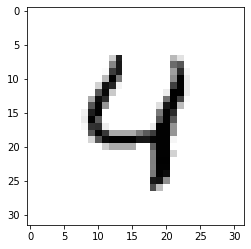

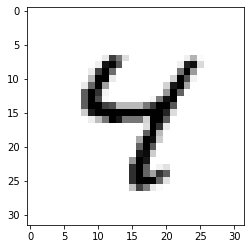

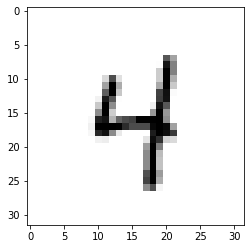

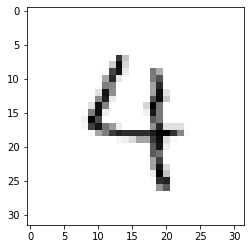

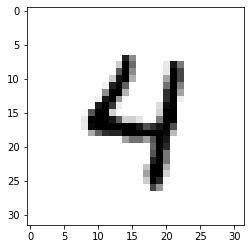

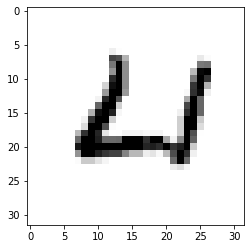

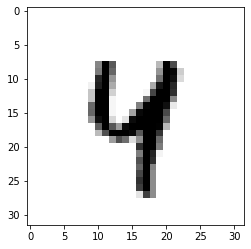

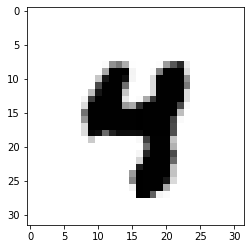

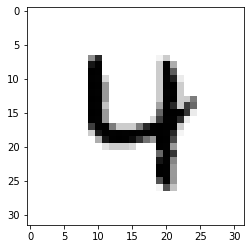

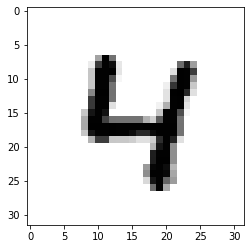

In [21]:
testNumber = 4
number_label_list = []
number_image_list = []
for image_features in test_dataset.take(1):
    label_list = image_features['label'].numpy()
    image_list = image_features["img"]
    print (image_features['label'])
    i = 0
    print(len(label_list))
    while i < len(label_list):

      if label_list[i] == testNumber:
 
        number_label_list.append(i)
        number_image_list.append(image_list[i])

        fig, ax = plt.subplots()
        plt.imshow(tf.squeeze(image_list[i], axis=-1), cmap='gray_r')

      i = i+1
# trg = number_image_list
# inv = flow.bijector.inverse(trg)
# re_trg = flow.bijector.forward(inv)
# re_inv = np.array([(inv[0] + inv[0]) / 2.0])
# print(re_inv.shape)
# re_re_trg = flow.bijector.forward(re_inv)

(32, 32)
(32, 32, 1)


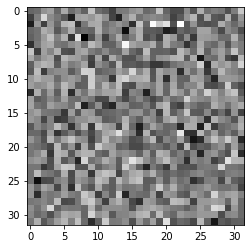

In [ ]:
z_1= np.random.normal(0, 1, (32, 32))
z_2 = np.random.normal(0, 1, (32, 32))
expz_1 = tf.expand_dims(z_1, axis=2)
expz_2 = tf.expand_dims(z_2, axis=2)
expz_1 = tf.cast(expz_1,dtype = tf.float32)
expz_2 = tf.cast(expz_2,dtype = tf.float32)

z = [expz_1, expz_2]
plt.imshow(z_1, cmap='gray_r')

plt.imshow(z_2, cmap='gray_r')

print(z_1.shape)
print(number_image_list[0].shape)



In [ ]:
def plot_generation_result(data):
    fig = plt.figure(figsize=(8, 8))
    
    trg = data
    inv = flow.bijector.inverse(trg)
    re_trg = flow.bijector.forward(inv)

    print('log probability: ', tf.reduce_mean(tfd.Normal(0., 1.).log_prob(inv)).numpy())
    print("inv mean: ", tf.reduce_mean(inv).numpy(), " std: ", tf.math.reduce_std(inv).numpy())
    print("re:trg mean: ", tf.reduce_mean(re_trg).numpy(), " std: ", tf.math.reduce_std(re_trg).numpy())

    re_inv = np.array([(inv[0] + inv[1]) / 2.0])
    print(re_inv.shape)
    re_re_trg = flow.bijector.forward(re_inv)

    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(tf.squeeze(trg[0], axis=-1), aspect="auto", cmap='gray_r')

    ax = fig.add_subplot(2, 3, 4)
    ax.imshow(tf.squeeze(re_trg[0], axis=-1), aspect="auto", cmap='gray_r')

    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(tf.squeeze(trg[1], axis=-1), aspect="auto", cmap='gray_r')

    ax = fig.add_subplot(2, 3, 5)
    ax.imshow(tf.squeeze(re_trg[1], axis=-1), aspect="auto", cmap='gray_r')

    ax = fig.add_subplot(2, 3, 3)
    ax.imshow(tf.squeeze(re_inv[0], axis=-1), aspect="auto", cmap='gray_r')

    ax = fig.add_subplot(2, 3, 6)
    ax.imshow(tf.squeeze(re_re_trg[0], axis=-1), aspect="auto", cmap='gray_r')

log probability:  -2.3826025
inv mean:  -1.09896064e-07  std:  1.7109436
re:trg mean:  -0.8178596  std:  0.5257823
(1, 32, 32, 1)


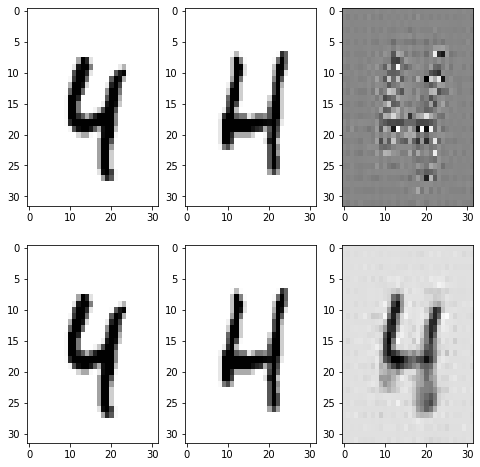

In [ ]:
plot_generation_result(number_image_list)

log probability:  -2.383402
inv mean:  -1.0523945e-07  std:  1.7114108
re:trg mean:  -0.0016124956  std:  1.0173244
(1, 32, 32, 1)


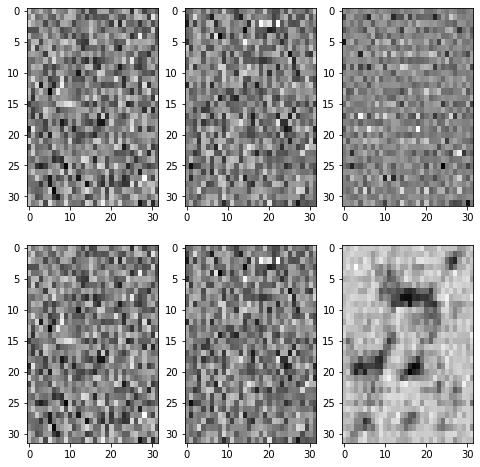

In [ ]:
plot_generation_result(z)

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets.mnist import load_data
from skimage.transform import resize
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))


<class 'numpy.ndarray'>
(2, 32, 32)
<class 'numpy.ndarray'>
(1, 32, 32)
Ground thruth images


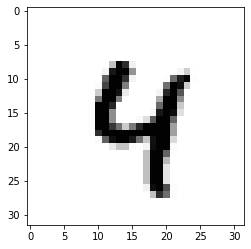

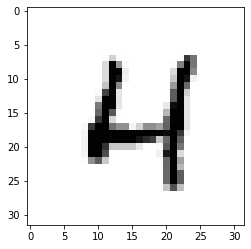

Images from Real NVP


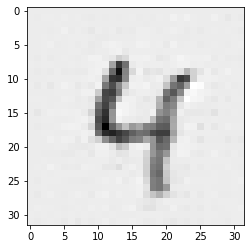

Loaded images ground truth (2, 32, 32) images from Real NVP (1, 32, 32)
FID: 254.270


In [ ]:
number_of_images_ground_truth=2
number_of_images_results_of_some_model=1

test_images1 = np.array([img.numpy() for img in number_image_list])
test_images1 = test_images1[:number_of_images_ground_truth].reshape((number_of_images_ground_truth,32,32))
ground_truth = test_images1
test_images2 = re_re_trg
test_images2 = np.array([img.numpy() for img in re_re_trg])
test_images2 = test_images2[:number_of_images_results_of_some_model].reshape((number_of_images_results_of_some_model,32,32))

print(type(test_images1))
print(test_images1.shape)
print(type(test_images2))
print(test_images2.shape)

print("Ground thruth images")
for i in range(number_of_images_ground_truth):
    img = test_images1[i].reshape((32,32))
    plt.imshow(img, cmap="Greys")
    plt.show()

print("Images from Real NVP")

for i in range(number_of_images_results_of_some_model):
    img = test_images2[i].reshape((32,32))
    plt.imshow(img, cmap="Greys")
    plt.show()

print('Loaded images ground truth', test_images1.shape, 'images from Real NVP',test_images2.shape)
# convert integer to floating point values
test_images1 = test_images1.astype('float32')
test_images2 = test_images2.astype('float32')
# resize images
test_images1 = scale_images(test_images1, (299,299,3))
test_images2 = scale_images(test_images2, (299,299,3))
#print('Scaled', images1.shape, images2.shape)
# pre-process images
test_images1 = preprocess_input(test_images1)
test_images2 = preprocess_input(test_images2)
# calculate fid
fid = calculate_fid(model, test_images1, test_images2)
print('FID: %.3f' % fid)


In [ ]:
print (type(ground_truth))
numpy.save('ground_truth', ground_truth, allow_pickle=True, fix_imports=True)


<class 'numpy.ndarray'>


# New Section

In [ ]:
data_1 = numpy.load('/content/ground_truth.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
print(type(data_1))
print (data_1.shape)
print()

<class 'numpy.ndarray'>
(2, 32, 32)

